In [4]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import graphviz
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sys
import os
%matplotlib inline
helper_path = os.path.abspath('/kaggle/titanic')
if helper_path not in sys.path:
    sys.path.append(helper_path)
import helper as hp
pd.set_option('display.expand_frame_repr', False) # display full data in terminal


In [5]:
df= pd.read_csv("/kaggle/titanic/data/train.csv")

# rename columns appropriately
# col_names_for_plot = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']
# col_names = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
X = df.drop(['Survived', 'Ticket', 'PassengerId'], axis=1)
y = df['Survived']

In [6]:
# create buckets for Age and Fare, and extract cabin letter and deck number, and title from name

def bucket_columns(data_frame):
    # Create age buckets in increments of 5 years
    data_frame['Age_Bucket'] = pd.cut(data_frame['Age'], 
                            bins=range(0, int(data_frame['Age'].max()) + 5, 5),
                            labels=[f'{i}-{i+4}' for i in range(0, int(data_frame['Age'].max()), 5)])

    # Create fare buckets - separate logic for <= 100 and > 100
    # Create fare buckets in increments of 50
    data_frame['Fare_Bucket'] = pd.cut(data_frame['Fare'],
                            bins=range(0, int(data_frame['Fare'].max()) + 50, 50),
                            labels=[f'{i}-{i+49}' for i in range(0, int(data_frame['Fare'].max()), 50)])


    # fare_bins = list(range(0, 110, 10)) + list(range(150, int(data_frame['Fare'].max()) + 50, 50))
    # fare_labels = [f'{fare_bins[i]}-{fare_bins[i+1]}' for i in range(len(fare_bins)-1)]
    # data_frame['Fare_Bucket'] = pd.cut(data_frame['Fare'], bins=fare_bins, labels=fare_labels)

    # Extract cabin letter and deck number
    data_frame['Cabin_Letter'] = data_frame['Cabin'].apply(get_letter)
    data_frame['Cabin_Deck'] = data_frame['Cabin'].apply(get_deck)
    data_frame['Cabin_Hall'] = data_frame['Cabin'].apply(get_hall)

    # extract title from name
    data_frame['Title'] = data_frame['Name'].apply(get_title)

    # drop all columns that have been bucketed or modified
    data_frame = data_frame.drop(columns=['Age', 'Fare','Cabin', 'Name'])
    return data_frame

def get_letter(cabin):
    if pd.isna(cabin) or cabin == "Unknown":
        return np.nan
    return cabin[0]

def get_deck(cabin):
    if pd.isna(cabin):
        return np.nan
    # Extract first number from cabin string
    numbers = ''.join(c for c in str(cabin) if c.isdigit())
    if numbers:
        # For numbers less than 100, return 0 as the deck
        return (int(numbers[0]) * 100) if int(numbers) >= 100 else 0
    return None

def get_hall(cabin):
    if pd.isna(cabin):
        return np.nan
    numbers = ''.join(c for c in str(cabin) if c.isdigit())
    if not numbers:
        return np.nan
    num = int(numbers)
    if num >= 100:
        return int(numbers[1]) * 10 # second digit
    elif num >= 10:
        return int(numbers[0]) * 10 # first digit
    else:
        return 0

def get_title(name):
    rare_titles = ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
    title_search = re.search(r' ([A-Za-z]+)\.', name)
    if not title_search:
        return ''
    title = title_search.group(1)
    if title in rare_titles:
        return 'Rare'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title == 'Mme':
        return "Mrs"
    return title

df_bucketed = bucket_columns(df.copy())


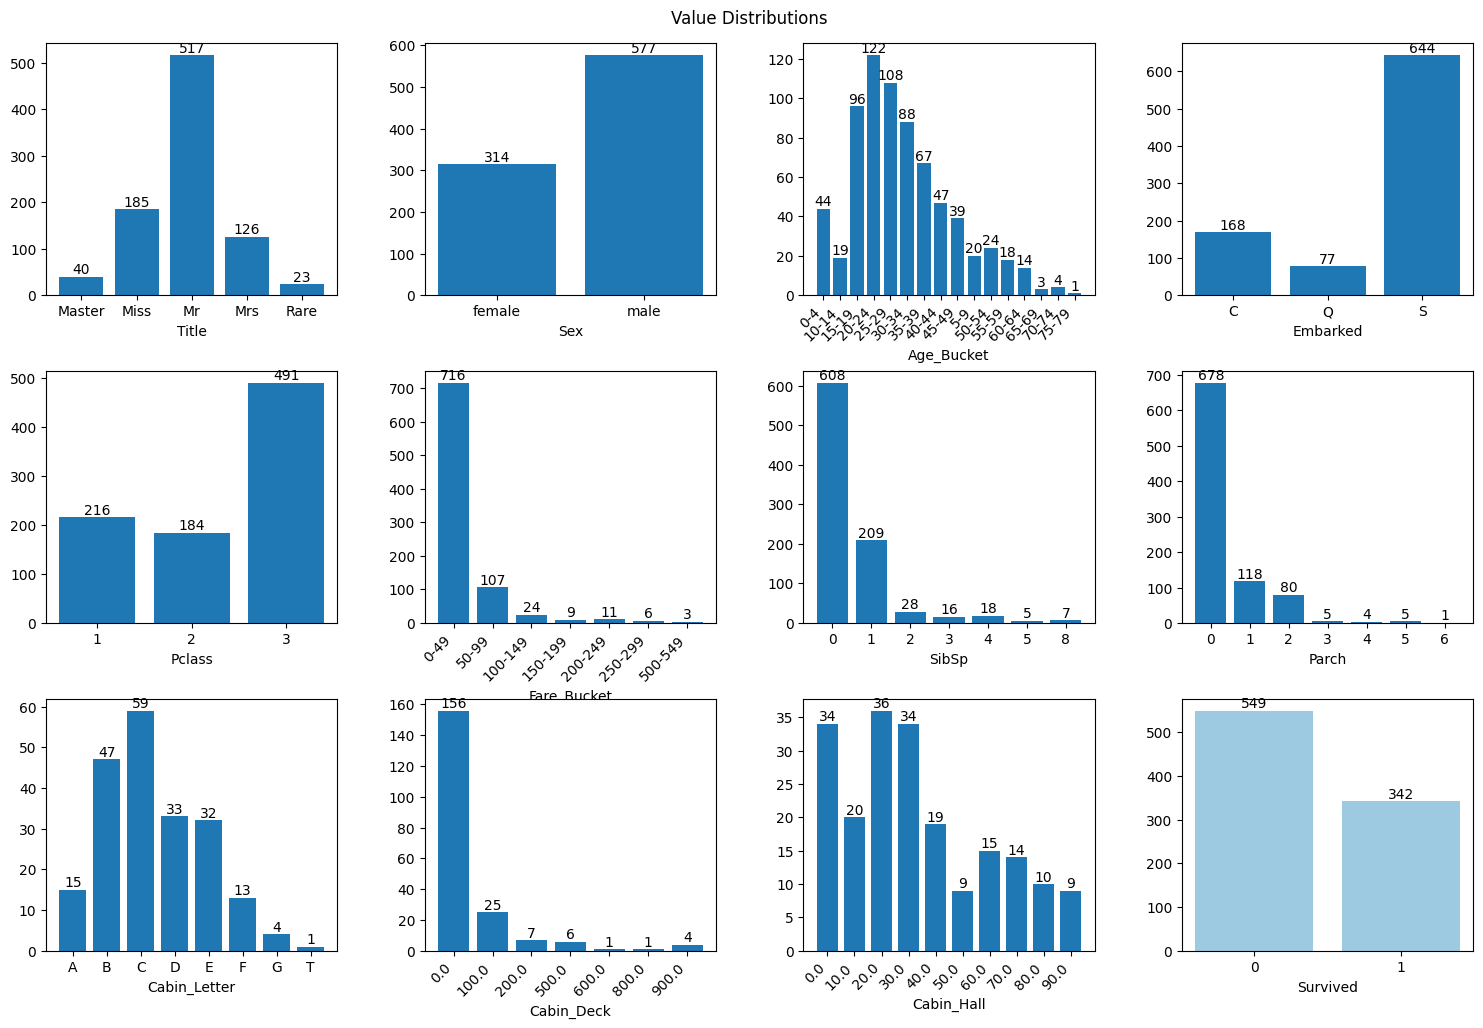

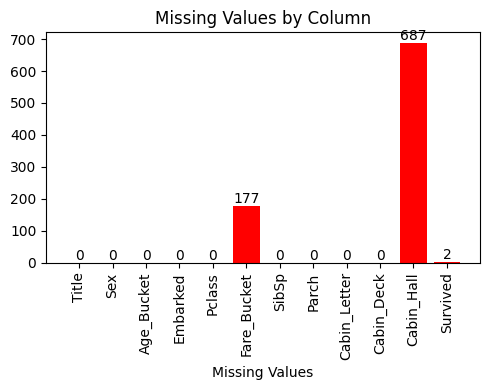

In [7]:
# Plot value distributions and Missing Data

def setup_plot():
    fig, ax = plt.subplots(3,4, figsize=(15,10))
    ax = ax.flatten()
    fig.suptitle("Value Distributions")
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    return fig, ax

# show distribution of values in each column.
def plot_value_counts(data, column, ax):
    vc = data[column].dropna().astype(str).value_counts().sort_index()
    # vc = data[column].dropna().value_counts().reindex([x for x in data[column].dropna().unique()]).sort_index()
    ax.set_xlabel(column)
    
         # Sort appropriately
    if column == 'Fare_Bucket':
        vc = vc.reindex(sorted(vc.index, key=lambda x: float(x.split('-')[0].strip())))

    # Set color for Survived column
    color = '#1f77b4' if column != 'Survived' else '#9ecae1'
    bars = ax.bar(range(len(vc)), vc.values, color=color)
    
    # Set x-tick labels
    ax.set_xticks(range(len(vc)))
    ax.set_xticklabels(vc.index)
    
    # Rotate labels for specific columns or if there are many categories
    if column in ['Age_Bucket', 'Fare_Bucket', 'Cabin_Deck', 'Cabin_Hall']:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

columns_to_plot = ['Title','Sex','Age_Bucket','Embarked','Pclass','Fare_Bucket','SibSp','Parch','Cabin_Letter','Cabin_Deck','Cabin_Hall','Survived'] # df_bucketed.columns.drop(['PassengerId', 'Ticket'])
def plot_missing_data(data_frame):
    plt.figure(figsize=(5,4))
    missing = data_frame.isna().sum()
    bars = plt.bar(missing.keys(), missing.values, color='r')
    plt.xlabel("Missing Values")
    plt.xticks(range(len(columns_to_plot)), columns_to_plot, rotation=90)
    hp.show_values_on_bar(bars, plt.gca())
    plt.title("Missing Values by Column")
    plt.tight_layout()

fix, ax = setup_plot()
for i, col in enumerate(columns_to_plot):
    plot_value_counts(df_bucketed, col, ax[i])
plot_missing_data(df);

In [8]:
# Impute missing age values using original numerical ages
# add title to df
X_imputed = X.copy()
X_imputed['Title'] = df['Name'].apply(get_title)
age_medians = X_imputed.groupby(['Title', 'Pclass'])['Age'].median()

# Create a function to get the imputed age based on Title and Pclass
def get_imputed_age(row):
    if pd.isna(row['Age']):
        return age_medians.get((row['Title'], row['Pclass']), 
                             df['Age'].median())  # Fallback to overall median
    return row['Age']

X_imputed['Age'] = X_imputed.apply(get_imputed_age, axis=1)

X_imputed['Embarked'] = X_imputed['Embarked'].fillna(X_imputed['Embarked'].mode()[0])
X_imputed['Cabin'] = X_imputed['Cabin'].fillna('Unknown')

X_imputed = bucket_columns(X_imputed)



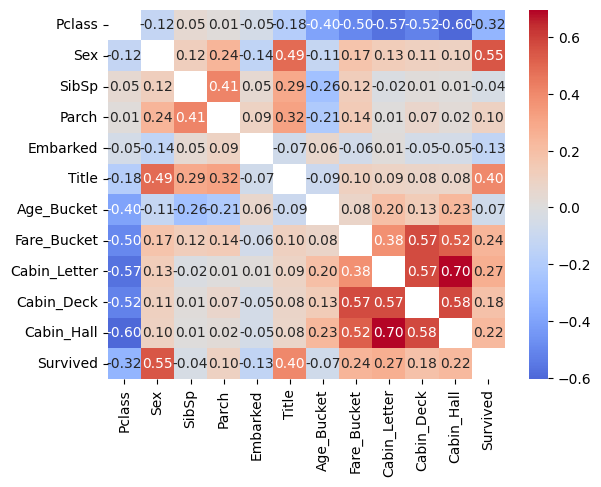

In [11]:
# Split data and transform to ordinals.
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y)

# transform to ordinals:

ordinal_mapping = [
    {'col': 'Sex', 'mapping': {'male': 0, 'female': 1}},
    {'col': 'Embarked', 'mapping': {'Q': 0, 'C': 1, 'S': 2}},
    {'col': 'Title', 'mapping': {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}},
    {'col': 'Age_Bucket', 'mapping': {
        '0-4': 0, '5-9': 1, '10-14': 2, '15-19': 3,
        '20-24': 4, '25-29': 5, '30-34': 6, '35-39': 7,
        '40-44': 8, '45-49': 9, '50-54': 10, '55-59': 11,
        '60-64': 12, '65-69': 13, '70-74': 14, '75-79': 15,
        '80-84': 16, '85-89': 17, '90-94': 18, '95-99': 19
    }},
    {'col': 'Fare_Bucket', 'mapping': {
        '0-49': 0, '50-99': 1, '100-149': 2, '150-199': 3,
        '200-249': 4, '250-299': 5, '300-349': 6, '350-399': 7,
        '400-449': 8, '450-499': 9, '500-549': 10
    }},
    {'col': 'Cabin_Letter', 'mapping': {
        'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7
    }},
    {'col': 'Cabin_Deck', 'mapping': {
        0: 0, 100: 1, 200: 2, 300: 3, 400: 4, 500: 5, 600: 6, 700: 7, 800: 8
    }},
    {'col': 'Cabin_Hall', 'mapping': {
        0: 0, 10: 1, 20: 2, 30: 3, 40: 4, 50: 5, 60: 6, 70: 7, 80: 8, 90: 9
    }}
]

oe = OrdinalEncoder(mapping=ordinal_mapping)
X_train = oe.fit_transform(X_train)
X_test = oe.transform(X_test)

# print ordinal mappings for nice viewing
# for mapping in ordinal_mapping:
#     print(f"\n{mapping['col']}:")
#     for key, value in mapping['mapping'].items():
#         print(f"  {key}: {value}")

# generate heatmap of correlation matrix, masking the diagonal
foo = X_train.copy()
foo["Survived"] = y_train
corr_matrix = foo.corr()
mask = np.eye(len(corr_matrix))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', mask=mask)
plt.show()


The lowest total gini score is achieved when splitting on Title at the value 0.


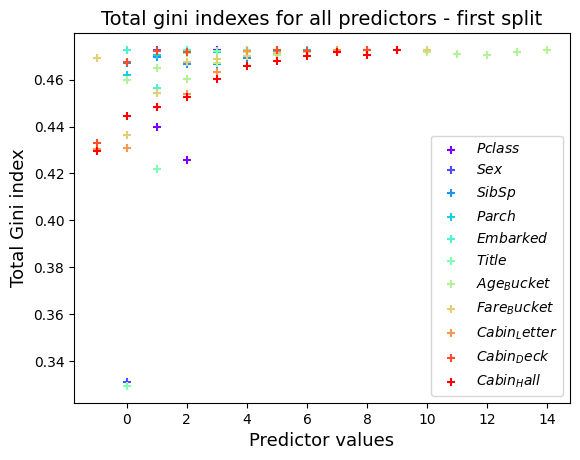

In [12]:
# VISUALIZE FIRST SPLIT with Gini Index

def get_total_gini(predictor_values, pred_name, df, response_col):
    '''
    Parameters: an array of _unique_ predictor values,
                a name of the predictor (String),
                a corresponding dataframe object.
    Returns: an array of total Gini index for each provided predictor value.
    '''
    total_gini = []
    
    # try each value as a potential split location
    for val in predictor_values:
    
        # Left Leaf
        # counts of each class (1 or 0) to the left of candidate split
        vc = df[df[pred_name] <= val][response_col].value_counts()
        left_1 = vc.get(1, 0)
        left_0 = vc.get(0, 0)
        
        # total number of points on the left
        # (max with small number to avoid devision by zero later)
        N_left = max(1e-5, left_1 + left_0)

        # Gini impurity for the left leaf
        gini_left = 1 - (left_1 / N_left)**2 - (left_0 / N_left)**2
    
        # Right Leaf
        # counts of each class (1 or 0) to the right of candidate split
        vc_right = df[df[pred_name] > val][response_col].value_counts()
        right_1 = vc_right.get(1, 0)
        right_0 = vc_right.get(0, 0)

        # total number of points on the right
        # (max with small number to avoid division by zero later)
        N_right = max(1e-5, right_1 + right_0)
        # Gini impurity for the right leaf
        gini_right = 1 - (right_1 / N_right)**2 - (right_0 / N_right)**2

        # total number of points in both leaves
        N_total = N_left + N_right
        # total weighted gini impurity index
        total_gini.append(N_left / N_total * gini_left + N_right / N_total * gini_right)
    
    return total_gini

# plot the resulting total Gini indexes for each predictor
def plot_gini_scores(gini_scores, unique_values, predictors):
    colors = plt.cm.rainbow(np.linspace(0, 1, len(predictors)))
    for i, (gini, value, predictor) in enumerate(zip(gini_scores, unique_values, predictors)):
        plt.scatter(value, gini, marker='+', color=colors[i], label=f"${predictor}$")

    plt.xlabel("Predictor values", fontsize="13")
    plt.ylabel("Total Gini index", fontsize="13")
    plt.title("Total gini indexes for all predictors - first split", fontsize="14")
    plt.legend()
    plt.show()

# print the best split
def report_splits(df, all_total_gini, all_unique_values):
     best_pred = np.argmin([min(x) for x in all_total_gini])
     best_gini_idx = np.argmin(all_total_gini[best_pred])
     best_pred_value = all_unique_values[best_pred][best_gini_idx]
     print(f"The lowest total gini score is achieved when splitting on {df.columns[best_pred]} at the value {best_pred_value}.")
     return best_pred_value, df.columns[best_pred]

# do all the above
def compare_all_gini_scores(df, response_col='y'):
    predictors = df.columns.drop(response_col)
    unique_values = []
    total_gini = []
    for predictor in predictors:
        u_values = df[predictor].unique()
        unique_values.append(u_values)
        total_gini.append(get_total_gini(u_values, predictor, df, response_col))
    
    report_splits(df, total_gini, unique_values)
    plot_gini_scores(total_gini, unique_values, predictors)

# combine X_train and y_train for gini calculation
df_for_gini = X_train.copy()
df_for_gini['Survived'] = y_train

compare_all_gini_scores(df_for_gini, response_col='Survived')

In [30]:
# choose columns i think are best based on the correlation matrix
X_train = X_train[['Pclass', 'Title', 'Cabin_Letter', 'Cabin_Deck', 'Cabin_Hall']]
X_test = X_test[['Pclass', 'Title', 'Cabin_Letter', 'Cabin_Deck', 'Cabin_Hall']]


In [31]:
# make decision tree models, and fit them
# TODO cross validation
# Create list of gini models with different max_depths
gini_models = []
for depth in range(2, 10):
    
    model = DecisionTreeClassifier(criterion='gini', max_depth=depth)
    model.fit(X_train, y_train)
    gini_models.append(model)
    # Assign each model to a variable named giniN where N is the depth
    globals()[f'gini{depth}'] = model

# Generate predictions for each model in gini_models
for model in gini_models:
    depth = model.get_params()['max_depth']
    y_pred_train = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f'Depth {depth} accuracy - Train: {train_accuracy:.4f}, Test: {test_accuracy:.4f}')


Depth 2 accuracy - Train: 0.7919, Test: 0.7534
Depth 3 accuracy - Train: 0.8024, Test: 0.7534
Depth 4 accuracy - Train: 0.8159, Test: 0.7668
Depth 5 accuracy - Train: 0.8249, Test: 0.7713
Depth 6 accuracy - Train: 0.8308, Test: 0.7713
Depth 7 accuracy - Train: 0.8323, Test: 0.7758
Depth 8 accuracy - Train: 0.8353, Test: 0.7713
Depth 9 accuracy - Train: 0.8383, Test: 0.7713


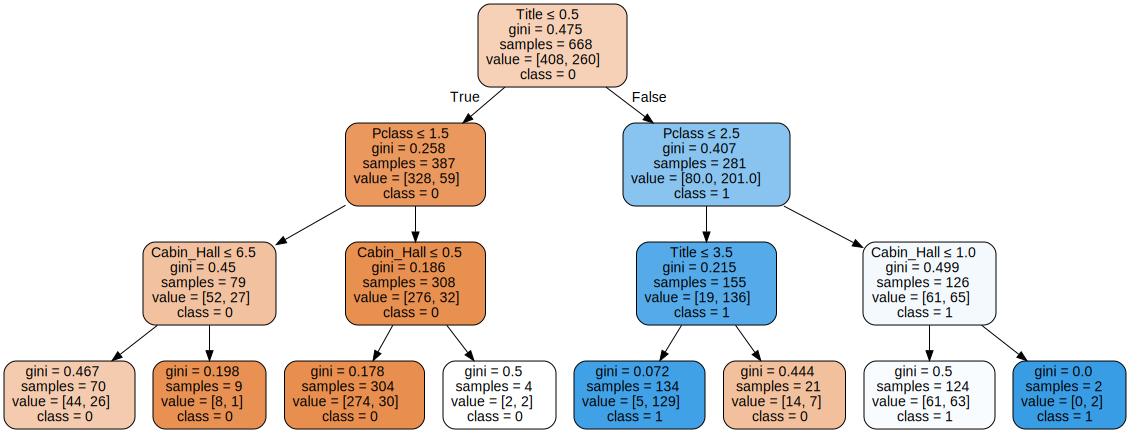

In [32]:
# better with graphviz
dot_data = tree.export_graphviz(gini3, out_file=None, 
                              feature_names=X_train.columns,  
                              class_names=['0', '1'],  
                              filled=True, rounded=True,  
                              special_characters=True)

graph = graphviz.Source(dot_data) 

graph 

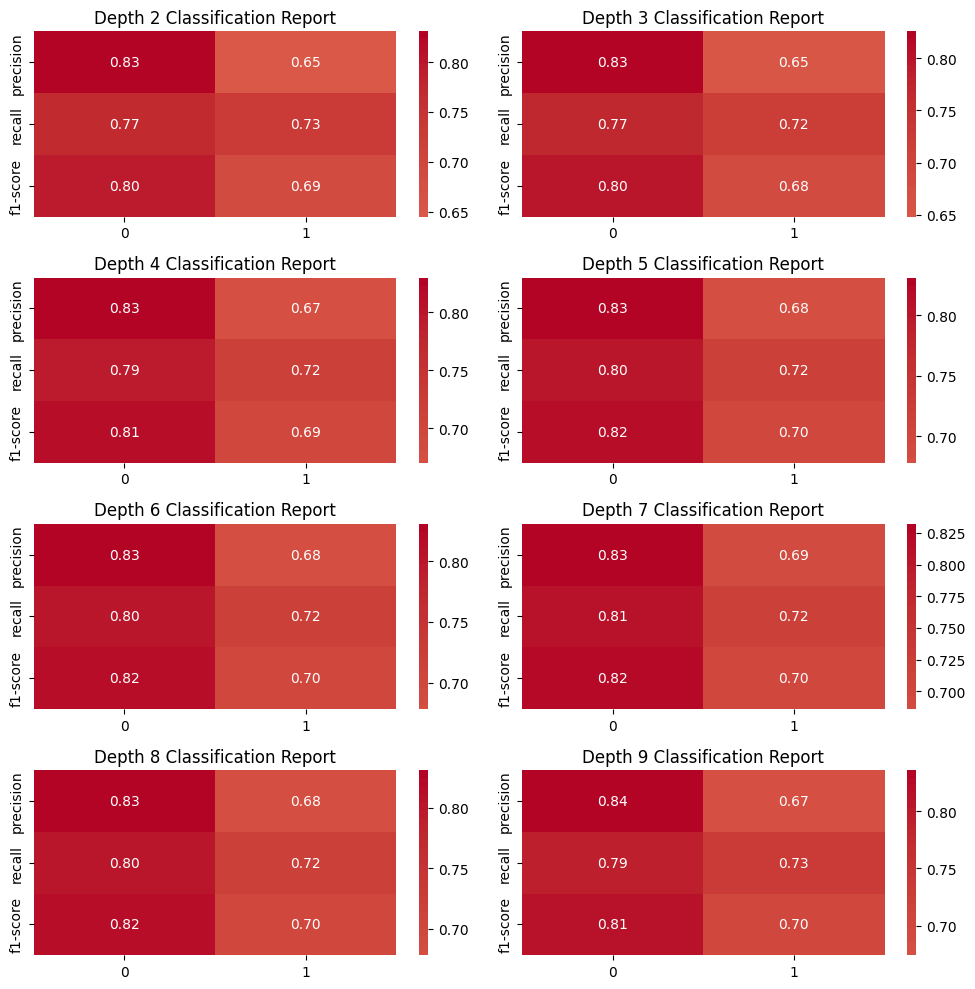

In [33]:
# Create subplots for all gini models
fig, axes = plt.subplots(4, 2, figsize=(10, 10))
axes = axes.ravel()

for i, model in enumerate(gini_models):
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Get classification report
    
    cr = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    # Convert to dataframe for heatmap
    cr_df = pd.DataFrame(cr)
    cr_df = cr_df.drop('support')
    cr_df = cr_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=1)
    
    # Create heatmap
    sns.heatmap(cr_df, annot=True, cmap='coolwarm', center=0, fmt='.2f', ax=axes[i])
    axes[i].set_title(f'Depth {model.get_params()["max_depth"]} Classification Report')

plt.tight_layout()
plt.show()
